In [1]:
#pip install -q -U "tensorflow-text==2.8.*"

In [2]:
#pip install -q tf-models-official==2.7.0

In [3]:
#!pip install keras tf-models-official pydot graphviz

In [4]:
#pip install pydot

In [5]:
import os

import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub

from keras.utils import np_utils

import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization as tokenization

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [6]:
tf.keras.backend.set_floatx('float16')
from tensorflow.keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3080, compute capability 8.6


In [7]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [8]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [9]:
data_train = pd.read_csv('C:/Users/liber/Desktop/Stats/4o Semestre/Aprendizado de Maquina/Aprendizado-de-M-quina-UFMG/Treino-Tweet.csv', encoding='latin-1')
data_train

,UserName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
...,...,...,...,...,...
41152,44951,"Wellington City, New Zealand",14-04-2020,Airline pilots offering to stock supermarket s...,Neutral
41153,44952,NaN,14-04-2020,Response to complaint not provided citing COVI...,Extremely Negative
41154,44953,NaN,14-04-2020,You know itÃÂs getting tough when @KameronWi...,Positive
41155,44954,NaN,14-04-2020,Is it wrong that the smell of hand sanitizer i...,Neutral


In [10]:
len(data_train.Location.unique())

12221

In [11]:
data_train = data_train.drop(['Location', 'UserName'], axis= 1)

In [12]:
data_train["Sentiment"].replace({"Extremely Negative":"Negative", "Extremely Positive":"Positive"}, inplace=True)
data_train

,TweetAt,OriginalTweet,Sentiment
0,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,16-03-2020,My food stock is not the only one which is emp...,Positive
4,16-03-2020,"Me, ready to go at supermarket during the #COV...",Negative
...,...,...,...
41152,14-04-2020,Airline pilots offering to stock supermarket s...,Neutral
41153,14-04-2020,Response to complaint not provided citing COVI...,Negative
41154,14-04-2020,You know itÃÂs getting tough when @KameronWi...,Positive
41155,14-04-2020,Is it wrong that the smell of hand sanitizer i...,Neutral


In [13]:
from numpy import int8
data_train = pd.get_dummies(data_train, columns= ["Sentiment"], drop_first= False, dtype=int8)
data_train

,TweetAt,OriginalTweet,Sentiment_Negative,Sentiment_Neutral,Sentiment_Positive
0,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,0,1,0
1,16-03-2020,advice Talk to your neighbours family to excha...,0,0,1
2,16-03-2020,Coronavirus Australia: Woolworths to give elde...,0,0,1
3,16-03-2020,My food stock is not the only one which is emp...,0,0,1
4,16-03-2020,"Me, ready to go at supermarket during the #COV...",1,0,0
...,...,...,...,...,...
41152,14-04-2020,Airline pilots offering to stock supermarket s...,0,1,0
41153,14-04-2020,Response to complaint not provided citing COVI...,1,0,0
41154,14-04-2020,You know itÃÂs getting tough when @KameronWi...,0,0,1
41155,14-04-2020,Is it wrong that the smell of hand sanitizer i...,0,1,0


In [14]:
data_train['Label'] = data_train[['Sentiment_Negative', 'Sentiment_Neutral', 'Sentiment_Positive']].values.tolist()

In [15]:
data_train = data_train.drop(['Sentiment_Negative', 'Sentiment_Neutral', 'Sentiment_Positive'], axis= 1)
data_train

,TweetAt,OriginalTweet,Label
0,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,"[0, 1, 0]"
1,16-03-2020,advice Talk to your neighbours family to excha...,"[0, 0, 1]"
2,16-03-2020,Coronavirus Australia: Woolworths to give elde...,"[0, 0, 1]"
3,16-03-2020,My food stock is not the only one which is emp...,"[0, 0, 1]"
4,16-03-2020,"Me, ready to go at supermarket during the #COV...","[1, 0, 0]"
...,...,...,...
41152,14-04-2020,Airline pilots offering to stock supermarket s...,"[0, 1, 0]"
41153,14-04-2020,Response to complaint not provided citing COVI...,"[1, 0, 0]"
41154,14-04-2020,You know itÃÂs getting tough when @KameronWi...,"[0, 0, 1]"
41155,14-04-2020,Is it wrong that the smell of hand sanitizer i...,"[0, 1, 0]"


In [16]:
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/2",
                            trainable=True)

In [17]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [18]:
tokenizer.convert_tokens_to_ids(['[CLS]', '[SEP]'])

[101, 102]

In [19]:
train, validation = train_test_split(data_train, test_size=0.15)
Tweets = train.OriginalTweet

In [20]:
def encode_names(n):
   tokens = list(tokenizer.tokenize(n))
   tokens.append('[SEP]')  # seperation token. Would bemuch more useful if you had a multiple text input.
   return tokenizer.convert_tokens_to_ids(tokens)

tweets_encoded = tf.ragged.constant([
    encode_names(n) for n in Tweets])

In [21]:
print('Tokenized Tweets shape', tweets_encoded.shape.as_list())

Tokenized Tweets shape [34983, None]


In [22]:
tweets_encoded[0]

<tf.Tensor: shape=(49,), dtype=int32, numpy=
array([ 14962,  13172,    108,  63131,  10123,  95596,  10149,  13028,
        17367,  10114,  55681,  10105,    108,  24960, 108986,  10350,
          136,  10747,  13575,  24952,  13028,    169,  87656,  57085,
        14120,    131,    120,    120,    188,    119,  11170,    120,
          176,  10350,  11517,  65111,  11703,  11373,  19282,  63051,
          108,  11170,  32194,  54055,    108,  31206,  37715,  10251,
          102])>

In [23]:
tokenizedTweet = tokenizer.tokenize(Tweets[0])
for i in tokenizedTweet:
  print(i, tokenizer.convert_tokens_to_ids([i]))

@ [137]
Me [11589]
##N [11537]
##yr [20728]
##bie [18545]
@ [137]
Phil [18144]
_ [168]
Ga [69699]
##han [11781]
@ [137]
Chris [13151]
##it [10486]
##v [10477]
https [14120]
: [131]
/ [120]
/ [120]
t [188]
. [119]
co [11170]
/ [120]
i [177]
##F [11565]
##z [10305]
##9 [11373]
##FA [38351]
##n [10115]
##2 [10729]
##Pa [89525]
and [10111]
https [14120]
: [131]
/ [120]
/ [120]
t [188]
. [119]
co [11170]
/ [120]
x [192]
##X [12674]
##6 [11211]
##gh [15774]
##G [11447]
##F [11565]
##z [10305]
##CC [65622]
and [10111]
https [14120]
: [131]
/ [120]
/ [120]
t [188]
. [119]
co [11170]
/ [120]
I [146]
##2 [10729]
##N [11537]
##lz [48275]
##d [10162]
##x [10686]
##N [11537]
##o [10133]
##8 [11396]


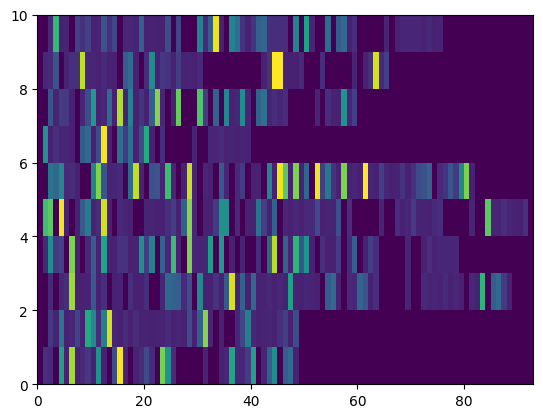

In [24]:
cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*tweets_encoded.shape[0]
input_word_ids = tf.concat([cls, tweets_encoded], axis=-1)
_ = plt.pcolormesh(input_word_ids[0:10].to_tensor())

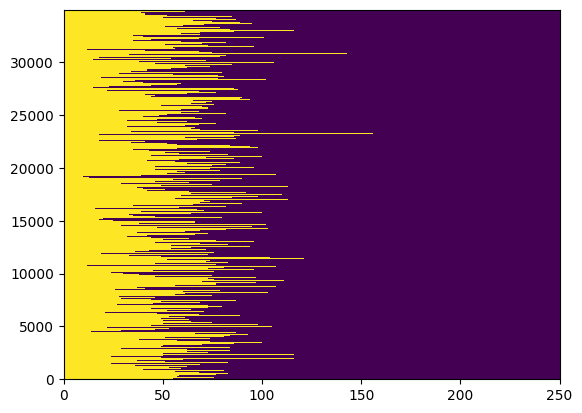

In [25]:
input_mask = tf.ones_like(input_word_ids).to_tensor()
plt.pcolormesh(input_mask)

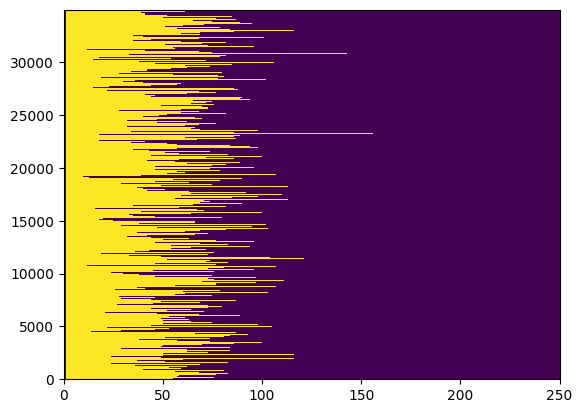

In [26]:
type_cls = tf.zeros_like(cls)
type_tweet = tf.ones_like(tweets_encoded)
input_type_ids = tf.concat([type_cls, type_tweet], axis=-1).to_tensor()

plt.pcolormesh(input_type_ids)

In [27]:
#lens = [len(i) for i in input_word_ids]
#max_seq_length = max(lens)
#print('Max length is:', max_seq_length)

In [28]:
max_seq_length = 275
print('Max length is:', max_seq_length)

Max length is: 275


In [29]:
def encode_names(n, tokenizer):
   tokens = list(tokenizer.tokenize(n))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

def bert_encode(string_list, tokenizer, max_seq_length):
  num_examples = len(string_list)
  
  string_tokens = tf.ragged.constant([
      encode_names(n, tokenizer) for n in np.array(string_list)])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*string_tokens.shape[0]
  input_word_ids = tf.concat([cls, string_tokens], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor(shape=(None, max_seq_length))

  type_cls = tf.zeros_like(cls)
  type_tokens = tf.ones_like(string_tokens)
  input_type_ids = tf.concat(
      [type_cls, type_tokens], axis=-1).to_tensor(shape=(None, max_seq_length))

  inputs = {
      'input_word_ids': input_word_ids.to_tensor(shape=(None, max_seq_length)),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return inputs

In [30]:
X_train = bert_encode(Tweets, tokenizer, max_seq_length)
X_val = bert_encode(validation.OriginalTweet, tokenizer, max_seq_length)

In [31]:
num_class = 3  # Based on available class selection
max_seq_length = max_seq_length  # we calculated this a couple cells ago

input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="segment_ids")

pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])                                  

output = tf.keras.layers.Dropout(rate=0.1)(pooled_output)

output = tf.keras.layers.Dense(num_class, activation='softmax', name='output', dtype='float32')(output)

model = tf.keras.Model(
    inputs={
        'input_word_ids': input_word_ids,
        'input_mask': input_mask,
        'input_type_ids': segment_ids
        },
        outputs=output)

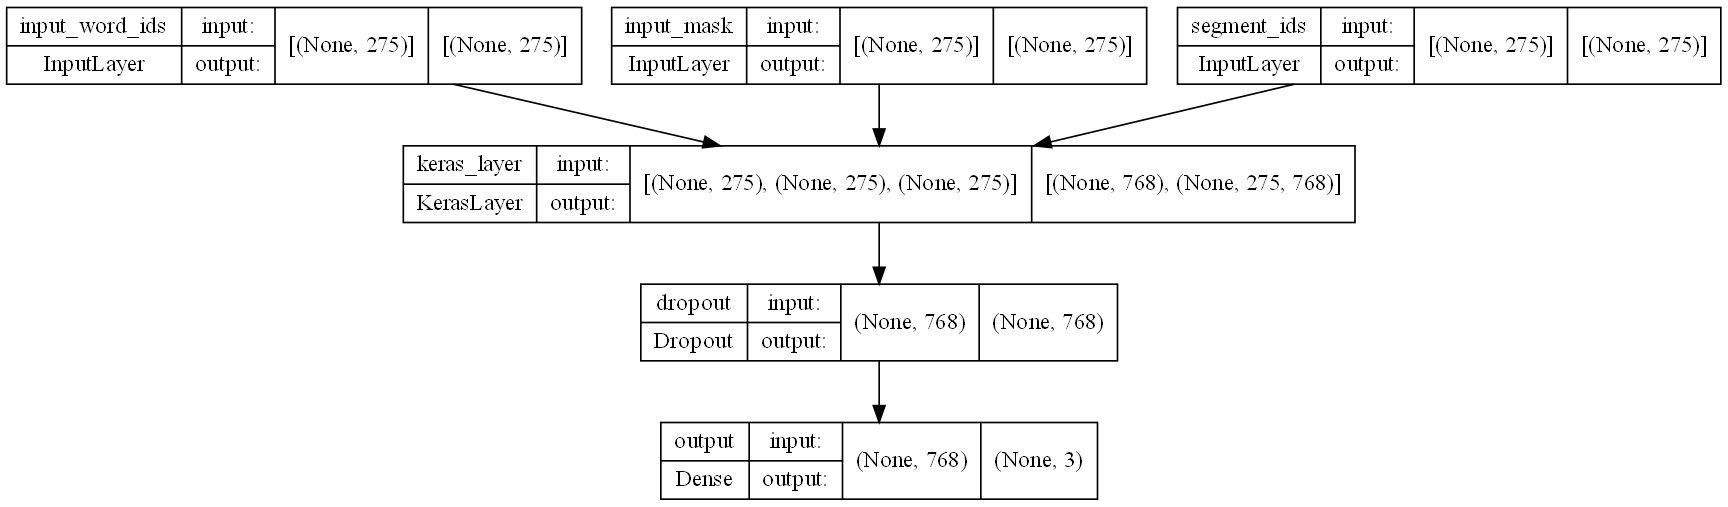

In [32]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=120)

In [33]:
Labels_train = np.array([np.array(i) for i in train.Label])
Labels_val = np.array([np.array(i) for i in validation.Label])

In [34]:
epochs = 4
batch_size = 10  # Maximo possivel com 11Gb de VRAM
eval_batch_size = batch_size

train_data_size = len(Labels_train)
steps_per_epoch = int(train_data_size / batch_size) 
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

optimizer = nlp.optimization.create_optimizer(
    2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps) #NAO MUDAR

In [35]:
#pip install tensorflow_addons

In [36]:
import tensorflow_addons as tfa
model.compile(optimizer=optimizer,
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy(), tfa.metrics.F1Score(num_classes=3), tfa.metrics.MultiLabelConfusionMatrix(num_classes=3)])

In [37]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 275)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 275)]        0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 275)]        0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 768),        177853441   ['input_word_ids[0][0]',         
                                 (None, 275, 768)]                'input_mask[0][0]',         

In [39]:
history = model.fit(
    x=X_train,
    y=Labels_train,
    batch_size = batch_size,
    epochs=epochs,
    verbose=1,
    callbacks=None,
    validation_data= (X_val, Labels_val),
    shuffle=True,
    class_weight=None,
    sample_weight=None
)

Epoch 1/4


C:\Users\liber\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("AdamWeightDecay/gradients/StatefulPartitionedCall:1", shape=(None,), dtype=int32), values=Tensor("mul_2:0", dtype=float32), dense_shape=Tensor("AdamWeightDecay/gradients/StatefulPartitionedCall:2", shape=(None,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


3499/3499 [==============================] - 750s 211ms/step - loss: 0.5892 - categorical_accuracy: 0.7596 - f1_score: 0.7443 - Multilabel_confusion_matrix: 8745.7500 - val_loss: 0.4414 - val_categorical_accuracy: 0.8456 - val_f1_score: 0.8375 - val_Multilabel_confusion_matrix: 1543.5000
Epoch 2/4
3499/3499 [==============================] - 749s 214ms/step - loss: 0.3074 - categorical_accuracy: 0.8944 - f1_score: 0.8879 - Multilabel_confusion_matrix: 8745.7500 - val_loss: 0.2876 - val_categorical_accuracy: 0.8973 - val_f1_score: 0.8891 - val_Multilabel_confusion_matrix: 1543.5000
Epoch 3/4
3499/3499 [==============================] - 749s 214ms/step - loss: 0.1922 - categorical_accuracy: 0.9353 - f1_score: 0.9292 - Multilabel_confusion_matrix: 8745.7500 - val_loss: 0.2780 - val_categorical_accuracy: 0.9070 - val_f1_score: 0.8985 - val_Multilabel_confusion_matrix: 1543.5000
Epoch 4/4
3499/3499 [==============================] - 765s 219ms/step - loss: 0.1179 - categorical_accuracy: 0.9

In [ ]:
#!mkdir 'C:\Users\liber\Desktop\Stats\4o Semestre\Aprendizado de Maquina\twitter_BERTv1.5'
#model.save('C:/Users/liber/Desktop/Stats/4o Semestre/Aprendizado de Maquina/twitter_BERTv1.5/model.h5')

In [40]:
data_test = pd.read_csv('C:/Users/liber/Desktop/Stats/4o Semestre/Aprendizado de Maquina/Aprendizado-de-M-quina-UFMG/Teste-Tweet.csv', encoding='utf-8')

from numpy import int8
Tweets_test = data_test.OriginalTweet
X_test = bert_encode(Tweets_test, tokenizer, max_seq_length)
data_test

,UserName,Location,TweetAt,OriginalTweet
0,1,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...
1,2,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...
2,3,NaN,02-03-2020,Find out how you can protect yourself and love...
3,4,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...
4,5,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...
...,...,...,...,...
3793,3794,Israel ??,16-03-2020,Meanwhile In A Supermarket in Israel -- People...
3794,3795,"Farmington, NM",16-03-2020,Did you panic buy a lot of non-perishable item...
3795,3796,"Haverford, PA",16-03-2020,Asst Prof of Economics @cconces was on @NBCPhi...
3796,3797,NaN,16-03-2020,Gov need to do somethings instead of biar je r...


In [41]:
Predictions = model.predict(X_test, verbose=1)
Predictions

119/119 [==============================] - 22s 184ms/step


array([[9.99722898e-01, 9.35107746e-05, 1.83543583e-04],
       [5.13511011e-04, 6.51454786e-04, 9.98835027e-01],
       [1.18295924e-04, 5.63607100e-05, 9.99825418e-01],
       ...,
       [2.97009554e-02, 2.55748659e-01, 7.14550376e-01],
       [9.98744011e-01, 5.54831582e-04, 7.01125420e-04],
       [1.73738896e-04, 5.12562729e-05, 9.99774992e-01]], dtype=float32)

In [42]:
Resultados = []
for i in Predictions:
    if np.argmax(i) == 0:
        Resultados.append("Negative")
    elif np.argmax(i) == 1:
        Resultados.append("Neutral")
    elif np.argmax(i) == 2:
        Resultados.append("Positive")
    else: 
        print(i)

In [43]:
data_test["Sentiment"] = Resultados
data_test

,UserName,Location,TweetAt,OriginalTweet,Sentiment
0,1,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Negative
1,2,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,NaN,02-03-2020,Find out how you can protect yourself and love...,Positive
3,4,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral
...,...,...,...,...,...
3793,3794,Israel ??,16-03-2020,Meanwhile In A Supermarket in Israel -- People...,Positive
3794,3795,"Farmington, NM",16-03-2020,Did you panic buy a lot of non-perishable item...,Negative
3795,3796,"Haverford, PA",16-03-2020,Asst Prof of Economics @cconces was on @NBCPhi...,Positive
3796,3797,NaN,16-03-2020,Gov need to do somethings instead of biar je r...,Negative


In [44]:
data_test.to_csv(r'C:\Users\liber\Desktop\Stats\4o Semestre\Aprendizado de Maquina\Aprendizado-de-M-quina-UFMG\TweetRespostas_FINALv1.csv')